Vanilla GAN from this website

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb


Combine into a DCGAN - 1D

https://github.com/LixiangHan/GANs-for-1D-Signal/blob/main/dcgan.py



In [1]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import time
from numpy.fft import fft, ifft

In [4]:
!pip install torchinfo
from torchinfo import summary


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import datetime
import os, sys
import scipy.io

In [6]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def to_onehot(x, num_classes=2): # create one-hot vectors for each classification
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [9]:
def get_sample_image(G, num_created, n_noise=100):
    """
        create augmented data from evaluated generator
    """

    for j in range(2):
        c = torch.zeros([num_created, 2]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(num_created, n_noise).to(DEVICE) # number of random noise vectors created = 10
        y_hat = G(z,c).view(num_created, 1, 1000)
        if j == 0: # this is a left movement
          data_left = y_hat.cpu().data.numpy()
        else:
          data_right = y_hat.cpu().data.numpy()
    return data_left, data_right

In [10]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=1000, condition_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 2048),
#            nn.LeakyReLU(0.2),
#            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        # x: [N, 3, 1000] c: [N, num_labels]
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float() # x: [N, 3000] c: [N, num_labels]
        v = torch.cat((x, c), 1) # v: [N, input + num labels]
        y_ = self.layer(v)
        return y_

In [11]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=2, num_classes=1000): # flag for later, should this be
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
           # nn.Linear(1024, 2048),
           # nn.BatchNorm1d(2048),
           # nn.LeakyReLU(0.2),
           # nn.Linear(2048, 4096),
           # nn.BatchNorm1d(4096),
           # nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x, c):
        # x: [N, 100] c: [N, num_labels]
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float() # x: [N, 102]
        v = torch.cat((x, c), 1) # v: [N, input + num_label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 1000)
        return y_

In [12]:
n_noise = 100

In [13]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [14]:
what_data_to_use = 'EEG_ALL'
#%cd /content/drive/MyDrive/CS230/GAN/EEG_2B_Data/
list_of_files = ['B0901T.mat', 'B0902T.mat', 'B0903T.mat', 'B0801T.mat', 'B0802T.mat', 'B0803T.mat','B0701T.mat', 'B0702T.mat', 'B0703T.mat',
                  'B0601T.mat', 'B0602T.mat', 'B0603T.mat', 'B0501T.mat', 'B0502T.mat', 'B0503T.mat', 'B0401T.mat', 'B0402T.mat', 'B0403T.mat',
                  'B0301T.mat', 'B0302T.mat', 'B0303T.mat', 'B0201T.mat', 'B0202T.mat', 'B0203T.mat', 'B0101T.mat', 'B0102T.mat', 'B0103T.mat']

if what_data_to_use == 'EEG_ALL':
  data =  np.empty((1000, 3, 3240)) # empty np array that concatenates all of the trials
  labels = [] #np.empty((3240,1))

  for idx in range(len(list_of_files)):
    target_tmp = scipy.io.loadmat(list_of_files[idx])
    data_tmp = target_tmp['data']
    label_tmp = target_tmp['label']
    data[:,:, idx*120:(idx+1)*120] = data_tmp
    for i in range(len(label_tmp)):
      if label_tmp[i] == 1.0:
        labels.append(0)
      else:
        labels.append(1)

  data = np.transpose(data, (2, 1, 0))
  label = np.array(labels).reshape(3240, 1)
    
elif what_data_to_use == 'EEG_ONE':
    data =  [] # empty np array that concatenates all of the trials
    labels = [] #np.empty((3240,1))
    temps= []
    target_tmp = scipy.io.loadmat(list_of_files[0])
    data_tmp = target_tmp['data']
    label_tmp = target_tmp['label']
    
    constant_right = data_tmp[:, 0, 0]
    constant_left = data_tmp[:, 0, 1]
    for i in range(3240): 
        indicator = np.random.randint(0,2)
        for j in range(3): 
            if indicator == 0: #left movement 
                temps.append(constant_left)
                if j == 0: 
                    labels.append(0)
            else: 
                temps.append(constant_right)
                if j ==0: 
                    labels.append(1)

    data = np.array(temps).reshape(3240,3,1000) 
    label = np.array(labels).reshape(3240, 1)
    
else: # sine  & cosine
  data = []
  temps = []
  labels = []
  t = np.linspace(0, 4, num=1000)

  for i in range(3240):
    indicator = np.random.randint(0,2)
    for j in range(3):
      variation_add = np.random.uniform(-.1,.1)
      if indicator == 0:  #left movement
        temps.append( (0.5 + variation_add) *np.sin(50*t) + 0.5)
        data += temps
        if j == 0:
          labels.append(0)
      else:
        temps.append( (0.5+variation_add) *np.cos(50*t) + 0.5)
        if j==0:
          labels.append(1)

  data = np.array(temps).reshape(3240,3,1000)
  label = np.array(labels).reshape(3240,1)



In [15]:
# normalize the data to be between [0, 1]
mins = []
maxes = []

for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    mins.append(np.min(data[i, j, :]))
    maxes.append(np.max(data[i, j, :]))
max_data = np.average(maxes)
min_data = np.average(mins)
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    data[i, j, :] = (data[i, j, :] - min_data) / (max_data - min_data)

In [16]:
#create dataset
class Sine_Cosine_Dataset(Dataset):
  def __init__(self, data, labels, transform=None):
    self.data = data
    self.labels = labels
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    label = self.labels[index]

    if self.transform:
      data = self.transform(data)

    return data, label

In [17]:
single_channel_data = data[:,0,:].reshape(3240,1,1000)

In [18]:
dataset = Sine_Cosine_Dataset(single_channel_data, label)

In [19]:
batch_size =128
condition_size=2

In [20]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.00015, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.00015, betas=(0.5, 0.999))

In [22]:
max_epoch = 1000 # need more than 10 epochs for training generator
step = 0
n_critic = 2 # for training more k steps about Discriminator

In [23]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [24]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [25]:
start_time = time.time()
Discriminator_loss = []
Generator_loss = []
steps = []
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE).float()
        y = labels.view(batch_size, 1).long()
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        
            
        step += 1
    print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
    Discriminator_loss.append(D_loss.item())
    Generator_loss.append(G_loss.item())
        
end_time = time.time()
elapsed_time = end_time - start_time 
print(f"Computation Time : {elapsed_time}")


Epoch: 0/1000, Step: 25, D Loss: 0.28331565856933594, G Loss: 2.278003215789795
Epoch: 1/1000, Step: 50, D Loss: 0.7219770550727844, G Loss: 4.086674690246582
Epoch: 2/1000, Step: 75, D Loss: 0.9333184957504272, G Loss: 1.526907205581665
Epoch: 3/1000, Step: 100, D Loss: 1.1977382898330688, G Loss: 0.9534870386123657
Epoch: 4/1000, Step: 125, D Loss: 1.3351354598999023, G Loss: 1.3298916816711426
Epoch: 5/1000, Step: 150, D Loss: 1.3911340236663818, G Loss: 0.9343764185905457
Epoch: 6/1000, Step: 175, D Loss: 1.3581969738006592, G Loss: 0.8597561120986938
Epoch: 7/1000, Step: 200, D Loss: 1.3480703830718994, G Loss: 0.8303834199905396
Epoch: 8/1000, Step: 225, D Loss: 1.3086621761322021, G Loss: 0.7329546213150024
Epoch: 9/1000, Step: 250, D Loss: 1.4220616817474365, G Loss: 0.8341344594955444
Epoch: 10/1000, Step: 275, D Loss: 1.3440479040145874, G Loss: 0.984939455986023
Epoch: 11/1000, Step: 300, D Loss: 1.3147106170654297, G Loss: 0.8720796704292297
Epoch: 12/1000, Step: 325, D Los

<function matplotlib.pyplot.show(close=None, block=None)>

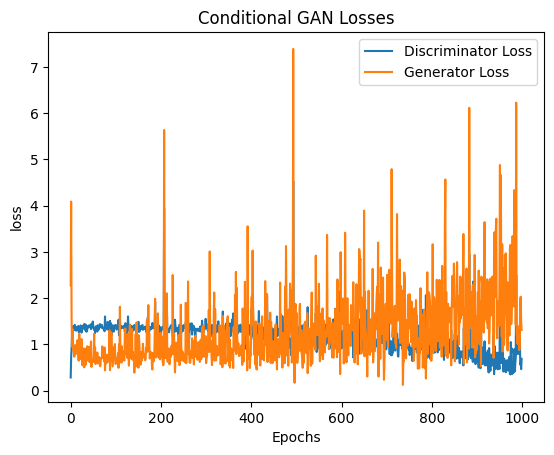

In [26]:
import matplotlib.pyplot as plt
#print(steps)
plt.plot(Discriminator_loss)
plt.plot(Generator_loss)
plt.title('Conditional GAN Losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show

In [27]:
G.eval()
data_left, data_right = get_sample_image(G, n_noise)
x = np.linspace(0, 4, num=1000)

In [28]:
#choose right and left
index_left = np.where(label == 0)[0][0]
index_right = np.where(label ==1)[0][0]

y_left = data[index_left, 0, :].squeeze()
y_right = data[index_right, 0,:].squeeze()


In [29]:
# sampling rate
sr = 250
# sampling interval
ts = 1.0/sr
t = np.arange(0,4,ts)
x = y_left

C:\Python Projects\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Python Projects\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


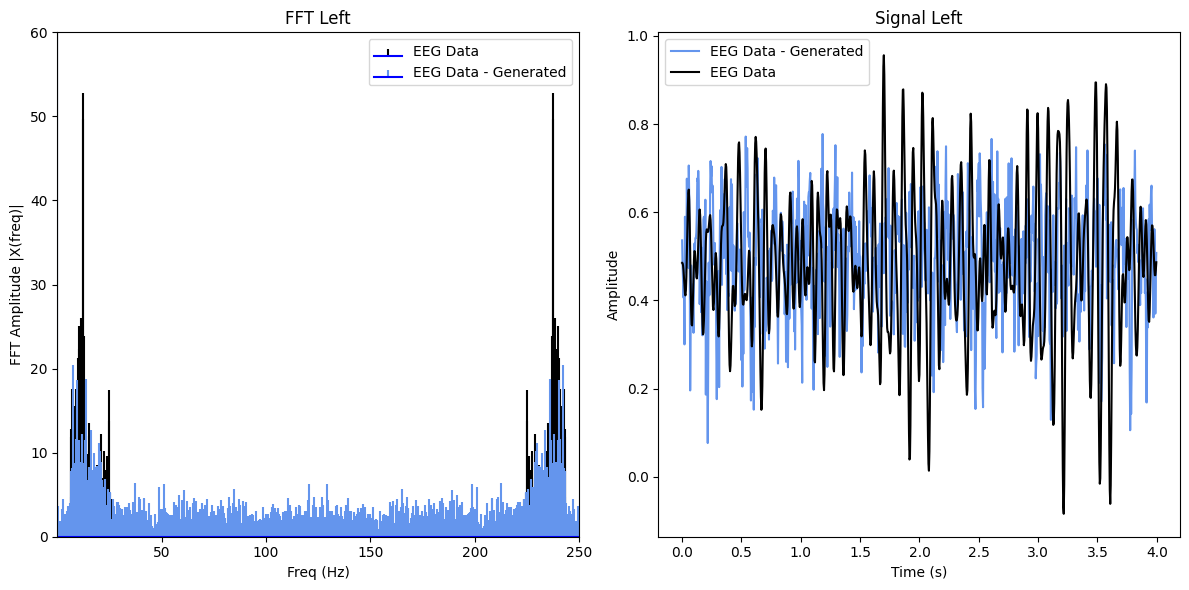

In [30]:
X_left = fft(y_left)
left_fft_gen = fft(data_left[0,:])
N = len(X_left)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_left), 'k', \
         markerfmt=" ", basefmt="-b", label='EEG Data')
plt.stem(freq, np.abs(left_fft_gen.squeeze()), 'cornflowerblue', \
         markerfmt=" ", basefmt="-b", label='EEG Data - Generated')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.1, 250)
plt.title('FFT Left')
plt.legend()
plt.ylim(0, 60)

plt.subplot(122)
plt.plot(t, ifft(left_fft_gen.squeeze()), 'cornflowerblue', label='EEG Data - Generated')
plt.plot(t, ifft(X_left), 'k', label='EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.title('Signal Left')
plt.legend()
plt.show()

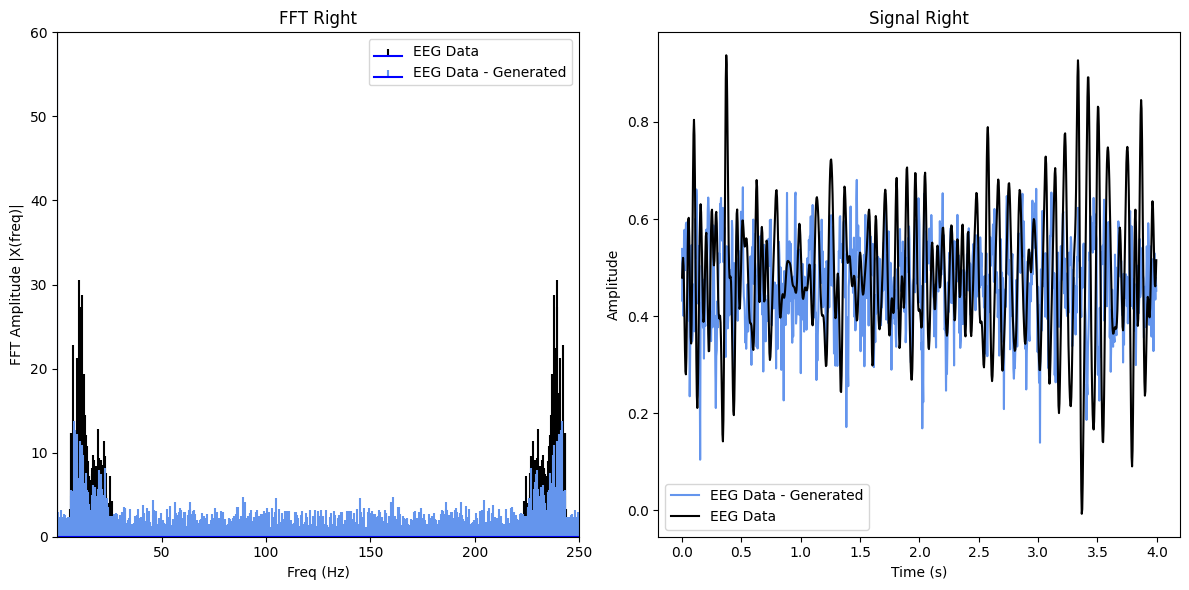

In [31]:


X_right = fft(y_right)
right_fft_gen = fft(data_right[0,:])
N = len(X_right)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_right), 'k', \
         markerfmt=" ", basefmt="-b", label='EEG Data')
plt.stem(freq, np.abs(right_fft_gen.squeeze()), 'cornflowerblue', \
         markerfmt=" ", basefmt="-b", label='EEG Data - Generated')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.1, 250)
plt.title('FFT Right')
plt.legend()
plt.ylim(0, 60)

plt.subplot(122)
plt.plot(t, ifft(right_fft_gen.squeeze()), 'cornflowerblue', label='EEG Data - Generated')
plt.plot(t, ifft(X_right), 'k', label='EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.title('Signal Right')
plt.legend()
plt.show()

In [32]:
# Save the Created Data
from numpy import savetxt
G.eval()
num_created = 3240
data_left, data_right = get_sample_image(G, num_created, n_noise)
# Reshape the 3d array into a 2d array
left_2d = data_left.reshape(data_left.shape[0], -1)
right_2d = data_right.reshape(data_right.shape[0], -1)

file_name_right = 'Conditional_GAN_Data/data_right' + str(num_created) + '.csv'
file_name_left = 'Conditional_GAN_Data/data_left' + str(num_created) + '.csv'
os.makedirs('Conditional_GAN_Data', exist_ok =True)
savetxt(file_name_left, left_2d, delimiter=',')
savetxt(file_name_right, right_2d, delimiter=',')

